# Preprocessing Part1  Jupiter Notebook: Creating a Dataframe and Handling Missing Values
This is the first preprocessing notebook. This notebook deals with getting the data scraped by the scrape.py script, creates dataframes from the lists (raw_csv) and does teh first part of the preprocessing: dealing with converting strings to floats, objects to datetime objects and handles null values.

1. part 1: create the dataframe from the scraped data

In [5]:
import pandas as pd

2. data cleaning: Dealing with the null values 

In [14]:
#first read csv dropped unnamed columns and inspect the first few rows
raw_df= pd.read_csv("./data/raw_data.csv")
raw_df.drop("Unnamed: 0", axis=1, inplace=True)
print(raw_df.shape) 

(4343, 6)


In [15]:
raw_df.shape

(4343, 6)

check if any of the comment rows are empty. If they are we are forced to drop this row as the main project revolves around nlp

In [16]:
raw_df['Comments'].isnull().values.sum()

1

drop any reviews that have no text as of now use to us.

In [17]:
raw_df.dropna(subset=['Comments'], inplace=True)

Now that rows with missing comments have been dropped lets look at the rest of the missing data. We will deal with the missing values by using scikit learn's imputers, that will impute the missing data in each column for us accoprding the to the most common value. First take a look at what columns have missing values:

In [18]:
raw_df['Satisfaction Reviews'].isnull().values.sum(), raw_df['Speed Reviews'].isnull().values.sum(), raw_df['Reliability Reviews'].isnull().values.sum(), raw_df['Customer Service'].isnull().values.sum()

(179, 468, 604, 265)

We can see that all the numerical columns have missing values. To decide if to use a simple imputer or an imputer that takes into account any possible correlations between the columns, let's first see if there are any correlations between the columns. We have:

* 179 missing satisfaction reviews
* 468 missing speed reviews
* 604 missing reliability reviews
* 231 missing customer service reviews
 
So let's look at a correlation matrix to see whether there is a correlation:
 


C:\Users\amilc\AppData\Local\Temp\ipykernel_144\1897695697.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =raw_df.corr()


<AxesSubplot: >

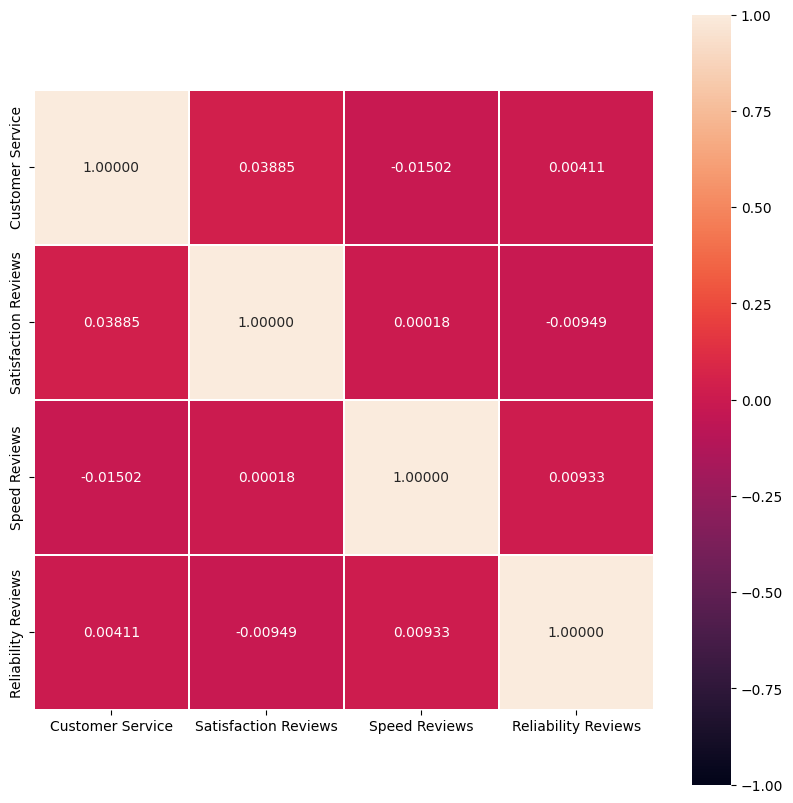

In [19]:
# Generate a mask for the upper triangle
corr =raw_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

#Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10,10))

# Draw the heatmap with 'sns.heatmap()'
   
sns.heatmap(corr, vmin=-1,vmax=1, square=True, fmt='.5f', linewidths='0.05', annot=True)


From the heatmap we can see that the strongest correlation (with a  value of -0.003398) is between Customer reviews and and Satisfaction Reviews, and coming after we have reliablity and speed reviews.

To account for these correlations we shall use a KNN Imputer. We shall use all the numerical features, and set  the n_neighbours=2 (this parameter can be fine tuned if required).

Here is how the algorithm works: Let's say that we have a row in which the speed reviews are missing. Scikit learn will find the two most similar rows (as neighbours =2) , measured to how close the the other features  (customer service, reliability, satisfaction) are to our original row and it averages the speed values of those rows and imputes the value in our orignal row.

Each row can have mulitple missing values, the algorithm takes that into account as well, there is logic for that.


In [20]:
imputer =KNNImputer() # neighbours are set to 5 by default
#fit on dataset
X=raw_df.drop(["Comments", "Dates"], axis=1)
imputer.fit(X)

# transform the dataset
Xtrans = imputer.transform(X)

In [21]:
raw_df.head()

,Dates,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews
0,2022-11-15,Moved back to the UK end of August and got Vir...,1.0,1.0,1.0,1.0
1,2022-11-14,"A truly attrocious service, both in terms of b...",1.0,1.0,1.0,1.0
2,2022-11-13,They make it as hard as they can for you to ca...,1.0,1.0,2.0,2.0
3,2022-11-11,Pay for the 350Mbps package but only ever mana...,1.0,1.0,3.0,2.0
4,2022-11-11,The worst customer service:\r-The bots ask irr...,1.0,1.0,3.0,2.0


In [22]:
dates_df =raw_df[["Dates"]]
comments_df=raw_df[["Comments"]]

In [23]:
#merging this dataframe with the other two daatframes
imputed_df = pd. DataFrame(Xtrans, columns=['Customer Service', 'Satisfaction Reviews', "Speed Reviews", "Reliability Reviews"]) 

When applying pd.concat with axis=1 to two dataframes results in redundant rows (usually also leading to NaNs in the columns of the first dataframe for previously not existing rows and NaNs in the columns of the second dataframe for previously existing rows), you may need to reset indexes of both dataframes before concatenating:


In [24]:
#this is the merged dataframe
knn_imputed= pd.concat([dates_df.reset_index(),comments_df.reset_index(), imputed_df.reset_index()],axis=1) 

now let's drop unnencessary data. We are building. The unecessary index columns resulting from the merging. And create a new colummn that computes the avearage score for each review. For each row, this column displays averages the scores of each of the review score.

In [25]:
knn_imputed.drop("index", axis=1, inplace=True)
knn_imputed["Average Score"]=knn_imputed.mean(axis=1) 

C:\Users\amilc\AppData\Local\Temp\ipykernel_144\3410277789.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  knn_imputed["Average Score"]=knn_imputed.mean(axis=1)


In [26]:
knn_imputed.to_csv('./data/preprocessed_data.csv')